In [18]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier

## Mesure des performances

In [19]:
# Retourne les mesures <precision>, <recall>, <accuracy> pour une prédiction donnée
def precision_recall_accuracy(ytrue, ypred):
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    accuracy = accuracy_score(ytrue, ypred)
    print(f"precision:{precision} | recall:{recall} | accuracy:{accuracy}")

# Recall = TP / (TP+FN) => Parmi les vrais à "1", combien ont été sélectionnés ?
# Precision = TP / (TP+FP) => Parmi les prédits à "1", combien le sont réellement ?
# Accuracy = (TP + TN) / (TP+TN+FP+FN) => Le nombre de bien prédits sur l'ensemble ("1" ou "0")

!["d"](https://miro.medium.com/max/724/1*Z54JgbS4DUwWSknhDCvNTQ.png)

## Division des données

In [20]:
# Divise le dataset selon la taille spécifiée
def split_train_test(X, y, size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=1)
    print(f"Taille du training set après réduction : X:{X_train.shape}, y:{y_train.shape}")
    print(f"Taille du test set après réduction : X:{X_test.shape}, y:{y_test.shape}")
    return X_train, X_test, y_train, y_test

## Sélection de features

In [21]:
# Nom des colonnes associées aux données d'entrée
COLS = np.array(["..."])

# Test les features du dataset pour choisir les meilleures
def feature_selection(X, y_train, X_test, y_test, nom_cols=COLS):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    importances=clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    sorted_idx = np.argsort(importances)[::-1]
    features = nom_cols
    padding = np.arange(X_train.size/len(X_train)) + 0.5 
    plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center') 
    plt.yticks(padding, features[sorted_idx]) 
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance") 
    plt.show()
    KNN=KNeighborsClassifier(n_neighbors=5)
    scores=np.zeros(X_train.shape[1]+1)
    for f in np.arange(0, X_train.shape[1]+1):
        X1_f = X_train[:,sorted_idx[:f+1]]
        X2_f = X_test[:,sorted_idx[:f+1]]
        KNN.fit(X1_f,y_train)
        YKNN=KNN.predict(X2_f)
        scores[f]=np.round(accuracy_score(y_test,YKNN),3)
    plt.plot(scores)
    plt.xlabel("Nombre de Variables")
    plt.ylabel("Accuracy")
    plt.title("Evolution de l'accuracy en fonction des variables")
    plt.show()


## Hyperparameter tuning

In [22]:
# Applique un algorithme GridSearch sur le modèle passé associé à ses arguments à test
# X et y doivent être l'ensemble du dataset (split dans GridSearch avec cross validation)
def gridsearch(X, y, model, opts):
    gs = GridSearchCV(model, opts, cv=5, scoring="accuracy")
    gs = gs.fit(X,y)
    print(f"Meilleur score : {gs.best_score_}")
    print(f"Meilleurs params : {gs.best_params_}")
    return gs

## Estimation de la fiabilité des classifieurs

In [23]:
# Liste de classifieur à tester
CLFS = {
    'LinearSVC': LinearSVC(random_state=1),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=1),
    'GaussianNB' : GaussianNB(),
    'RF': RandomForestClassifier(random_state=1),
    'SGDClassifier': SGDClassifier(random_state=1),
    'LogisticRegression': LogisticRegression(random_state=1),
    "AdaBoost": AdaBoostClassifier(random_state=1),
    "MultilayerPerceptron": MLPClassifier(random_state=1),
    "Bagging": BaggingClassifier(base_estimator=SVC(), random_state=1)
}

# Evaluation des classifieur spécifiés avec cross-validation
def kfcv_test_classifiers(X, y, scaler=StandardScaler(), clfs=CLFS):
    kf = KFold(n_splits=10, shuffle=True, random_state=1)        
    for i in clfs:
        clf = clfs[i]
        time_begin = time.time()
        if scaler != None:
            clf = make_pipeline(scaler, clf)
        cv_acc = cross_val_score(clf, X, y, scoring='accuracy', cv=kf)
        time_end = time.time()
        print(f"Classifier {i} : ")
        print(f"\tExecution time = {time_end-time_begin}")
        print("\tAccuracy : {0:.3f} +/- {1:.3f}".format(np.mean(cv_acc), np.std(cv_acc)))

## Chargement des données

Taille des données : (1631, 22)
Taille du training set après réduction : X:(1092, 22), y:(1092,)
Taille du test set après réduction : X:(539, 22), y:(539,)


,ID,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,Classe
0,1,114,3,0,3,24,3.2,0,16.2,2,...,52,186,8,0,117,115,117,19,0,0
1,2,115,5,52,3,22,3.6,0,19.6,1,...,50,188,8,0,117,117,119,21,0,0
2,3,115,9,54,5,27,2.3,0,12.4,0,...,53,182,7,0,119,120,120,14,0,0
3,4,114,10,69,8,28,2.2,0,12.2,1,...,55,153,7,1,119,119,120,13,0,0
4,5,114,4,31,6,27,2.4,0,13.5,0,...,54,182,6,0,119,118,119,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,1627,132,0,64,1,29,2.9,0,15.1,7,...,50,194,11,1,133,124,130,35,0,0
1627,1628,120,9,123,1,28,3.4,0,21.7,1,...,55,181,13,0,121,124,126,25,0,0
1628,1629,120,6,56,1,28,3.2,0,12.4,1,...,53,181,9,1,129,125,127,25,0,0
1629,1630,120,5,90,6,27,3.7,0,24.2,0,...,51,195,11,0,125,124,126,24,0,0


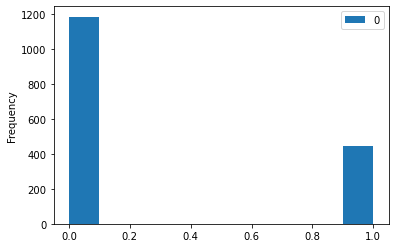

In [24]:
NB_FEATURES = 23 #Hardcodé

data = pd.read_csv('./XXX.csv', sep=';') 

X = data.iloc[:, 1:NB_FEATURES].values # On ne prend pas en compte l'id
y = data.iloc[:, NB_FEATURES].values.astype(float)

# X exemples de Y features
print(f"Taille des données : {X.shape}")

# Répartition des classes du training set
pd.DataFrame(y).plot.hist()

# Division du dataset
X_train, X_test, y_train, y_test = split_train_test(X, y)

# Print dataset
data

## Choix du meilleur classifieur (au monde)

*Pour faciliter le choix : [lien](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)*

In [25]:
# Donne un premier apperçu des performances
kfcv_test_classifiers(X,y)

Classifier LinearSVC : 
	Execution time = 0.19416236877441406
	Accuracy : 0.925 +/- 0.022
Classifier KNN : 
	Execution time = 0.08836555480957031
	Accuracy : 0.914 +/- 0.019
Classifier SVC : 
	Execution time = 0.349409818649292
	Accuracy : 0.928 +/- 0.021
Classifier GaussianNB : 
	Execution time = 0.06255960464477539
	Accuracy : 0.886 +/- 0.026
Classifier RF : 
	Execution time = 1.7399826049804688
	Accuracy : 0.960 +/- 0.010
Classifier SGDClassifier : 
	Execution time = 0.04804348945617676
	Accuracy : 0.917 +/- 0.016
Classifier LogisticRegression : 
	Execution time = 0.10408854484558105
	Accuracy : 0.926 +/- 0.020
Classifier AdaBoost : 
	Execution time = 0.930213212966919
	Accuracy : 0.950 +/- 0.019
Classifier MultilayerPerceptron : 
	Execution time = 9.74360466003418
	Accuracy : 0.947 +/- 0.016
Classifier Bagging : 
	Execution time = 1.6813812255859375
	Accuracy : 0.924 +/- 0.023


In [26]:
# Modèle(s) retenu(s)
model = MLPClassifier()

# Pipeline de classification
pipe = Pipeline([
        ('scaler', MinMaxScaler()),                # Etape 1 : normalisation
        ('reduce_dims', PCA(n_components=15)),     # Etape 2 : réduction de dimension
        ('clf', model)])                           # Etape 3 : classification

opts = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'clf__hidden_layer_sizes': [(20,10),(20,)],
    'clf__activation': ['tanh', 'relu'],
    'clf__solver': ['sgd', 'adam'],
    'clf__alpha': [0.0001, 0.001, 0.05],
    'clf__learning_rate': ['constant','adaptive'],
    'clf__random_state': [1]
}

gs = gridsearch(X, y, pipe, opts)

In [27]:
# Training
pipe.fit(X_train,y_train)

# Testing
y_pred = pipe.predict(X_test)
precision_recall_accuracy(y_test,y_pred)

precision:0.972027972027972 | recall:0.879746835443038 | accuracy:0.9573283858998145


## Application sur le jeu de test

In [28]:
# On récupère les données de test
data_eval = pd.read_csv('./XXX.csv', sep=';') 
X_eval = data_eval.iloc[:, 1:NB_FEATURES].values 
X_eval_id = data_eval["ID"].values # ID des exemples

# 1631 exemples de 22 features
print(f"Taille des données : {X_eval.shape}")

# Predict avec le modèle entrainé (pipeline en fait)
y_pred = pipe.predict(X_eval)

# Juste pour être sûr
assert(X_eval_id.shape[0] == y_pred.shape[0])

# Trick pour récupérer le nombre de 0 et de 1
# Pas très propre cela dit...
# Predicitons : 315 de la classe "0" et 180 de la classe "1"
print(np.histogram(y_pred,bins=[0,0.5,1])) 

# Sauvegarde dans un CSV
pd.DataFrame({"id":X_eval_id,"pred":y_pred}).to_csv("OUT.csv", sep=";", header=False, index=False)

Taille des données : (495, 22)
(array([315, 180], dtype=int64), array([0. , 0.5, 1. ]))
Voila c'est dans la boite.
